# Global constants

In [610]:
#GRAIN_TYPE = 'Wheat'
#GRAIN_TYPE = 'newWheatData'
GRAIN_TYPE = 'CornAdded_Type'
# GRAIN_TYPE = 'Oats'
# GRAIN_TYPE = 'Barley'
# GRAIN_TYPE = 'Sorghum'
# GRAIN_TYPE = 'Soybeans'
# GRAIN_TYPE = 'Corn'

FILENAME_BEST_MODEL = 'Best models/target_2/hybrid_models/' + GRAIN_TYPE + '_t2_kcv_dnn_mc.h5'

In [611]:
#Import libraries
import requests
import pydot
import pandas as pd


#Data visualization
import seaborn as sn
import matplotlib.pyplot as plt
import random
#Data Manipulation
import pandas as pd
import numpy as np

# Machine Learning
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Activation, BatchNormalization
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split, KFold
np.random.seed(39)
random.seed(39)
tf.random.set_seed(39)
print(tf.__version__)

2.4.1


In [612]:
print(tf.config.list_physical_devices('GPU'))
# print(tf.version.VERSION)

[]


## Helper functions

In [613]:
def calculate_r_squared(y_true, y_pred):
   corr_matrix = np.corrcoef(y_true, y_pred)
   corr = corr_matrix[0,1]
   R_sq = corr**2
   return R_sq

def plot_loss_curve(history, epoch_size):
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    epochs = range(0,epoch_size)
    
    plt.plot(epochs, loss_train, 'g', label='Training loss')
    plt.plot(epochs, loss_val, 'b', label='Validation loss')
    
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.legend()
    plt.show()

def plot_line(metric, title, xlabel):
    plt.figure(figsize=(8,3))
    plt.title(title, fontsize = 16)
    plt.plot(metric)
    plt.xlabel(xlabel, fontsize = 14)
    plt.grid()
    plt.legend(loc= "best")
    plt.show()

def scatter_plot(trueValues, predictions, title):
  plt.figure(figsize=(8,3))
  ax = plt.axes()
  maxVal = max( max(trueValues), max(predictions) )

  ax.scatter(x=predictions, y=trueValues)
  ax.plot([0, 1, maxVal], [0, 1, maxVal], label="Ideal fit")
  print('Maxval here is: ', maxVal)
  plt.title(title, fontsize = 16)
  plt.xlabel("Predictions", fontsize = 14)
  plt.ylabel("Real", fontsize = 14)
  plt.grid()

In [614]:
#url dataset
URL = "../Datasets/processed/" + GRAIN_TYPE + ".csv"

#read in excel format
df = pd.read_csv(URL)
#df = df[df['Variety'] == 'KANSAS']
#df = df[(df['Density'] >= 0.72) & (df['Density'] <= 0.88)]

print("From USDA: ", URL)


df.head()

From USDA:  ../Datasets/processed/CornAdded_Type.csv


,Unnamed: 0,Variety,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn
0,0,HI BRED 31D58,6.0,3.3,26.23,0.5602,9.2688,142.982,-217.018,3.595,0.984,26.271327,15.426161
1,1,HI BRED 31D58,7.0,3.3,26.23,0.5602,11.9033,114.498,-245.502,3.476,1.067,26.271327,9.619013
2,2,HI BRED 31D58,8.0,3.3,26.23,0.5602,14.9916,85.785,-274.215,3.383,1.163,26.271327,5.722204
3,3,HI BRED 31D58,9.0,3.3,26.23,0.5602,17.7882,63.083,-296.917,3.252,1.205,26.271327,3.546340
4,4,HI BRED 31D58,10.0,3.3,26.23,0.5602,20.2646,38.844,-321.156,3.165,1.224,26.271327,1.916840


# 2. Overview of data


In [615]:
# Data summary
df.describe()

,Unnamed: 0,Freq,d(cm),M%,Density,Attn,Phase,Phase_Corr,Permittivity_real,Permittivity_imaginary,Type,Phase/Attn
count,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000,1325.000000
mean,667.980377,9.616604,5.283170,19.173464,0.732730,18.574415,7.843992,-462.193766,3.241382,0.900775,19.173464,1.172074
std,388.591085,3.036191,2.049772,7.206516,0.101502,6.337757,89.287814,190.960971,0.603906,0.508211,4.172839,6.073271
min,0.000000,5.000000,2.000000,8.060000,0.448800,8.002300,-179.974000,-1115.206000,2.405000,0.242000,10.530000,-16.206737
25%,331.000000,7.000000,3.300000,13.910000,0.663100,13.112200,-54.978000,-573.131000,2.780000,0.477000,15.875592,-2.823299
50%,662.000000,9.000000,4.400000,18.580000,0.748300,18.344300,11.128000,-402.701000,3.094000,0.821000,18.743091,0.566702
75%,1007.000000,12.000000,7.700000,25.430000,0.816100,24.152200,77.870000,-323.806000,3.526000,1.213000,22.657120,4.866332
max,1338.000000,18.000000,8.500000,34.400000,0.901700,29.897000,179.949000,-150.217000,5.979000,3.294000,26.271327,20.488695


In [616]:
# Dimension of the dataset
df.shape

(1325, 13)

In [617]:
# Check info about missing values in dataframe
df.isnull().sum()

Unnamed: 0                0
Variety                   0
Freq                      0
d(cm)                     0
M%                        0
Density                   0
Attn                      0
Phase                     0
Phase_Corr                0
Permittivity_real         0
Permittivity_imaginary    0
Type                      0
Phase/Attn                0
dtype: int64

# Exploratory Data Analysis


# Data preparation


1.   Convert dataframe to numpy array for flexibility.
2. Split our data into training and testing datasets and store the target values in different variables.
3.   Normalize the features by applying some operations in the data sets.




In [618]:
# Convert to numpy array
df_features = df[['Freq', 
                    'd(cm)', 
                    'Attn', 
                    'Phase', 
                    'Phase_Corr', 
                    'Permittivity_real', 
                    'Permittivity_imaginary',
                    'Type']]

df_targets = df[['M%', 'Density']]
# df_targets = df[['Density', 'M%']]

dataset_x = df_features.to_numpy()
dataset_y = df_targets.to_numpy()

## Splitting dataset to test and train+validate

In [619]:
# Perform train-test split on RAW DATA
X_trainVal, X_test, y_trainVal, y_test = train_test_split(dataset_x, dataset_y, 
                                                    test_size=0.15
                                                    ,random_state=42
                                                    )

X_train, X_val, y_train, y_val = train_test_split(X_trainVal, y_trainVal, 
                                                    test_size=0.15 #validation split
                                                    ,random_state=42
                                                    )

## Normalize datasets

In [620]:
from sklearn.preprocessing import MinMaxScaler

#Normalizing the data set
scaler_input = MinMaxScaler()
scaler_output = MinMaxScaler()

# Normalize Train set
X_train_norm = scaler_input.fit_transform(X_train)
y_train_norm = scaler_output.fit_transform(y_train)

# Normalize Validation set
X_val_norm = scaler_input.fit_transform(X_val)
y_val_norm = scaler_output.fit_transform(y_val)

# Normalize the entire dataset (input features)
dataset_x_norm = scaler_input.transform(dataset_x)  # Use transform, NOT fit_transform

# Normalize the entire dataset (output targets)
dataset_y_norm = scaler_output.transform(dataset_y)  # Use transform, NOT fit_transform


# K-cross Validation
* Input features: 7
* Output targets: 2


## Defining model

In [621]:
from keras import layers, Sequential, regularizers

# Define the model-building function
def my_model():
  my_model = Sequential([
    
    layers.Dense(64, input_shape=(8,), activation='relu', 
                #  kernel_regularizer=regularizers.l2(0.01)
                 ),
    # layers.BatchNormalization(),  # Batch normalization layer
    # layers.Dropout(0.1),


    layers.Dense(64, activation='relu', 
                # kernel_regularizer=regularizers.l2(0.01)
                ),
    # layers.BatchNormalization(),  # Batch normalization layer
    # layers.Dropout(0.1),````

    layers.Dense(64, activation='relu', 
                # kernel_regularizer=regularizers.l2(0.01)
                ),
    # layers.BatchNormalization(),  # Batch normalization layer
    # layers.Dropout(0.2),
    
    layers.Dense(2, activation='linear')  # Output layer with 2 neurons for the two regression targets
  ])

  opt = tf.keras.optimizers.Adam(learning_rate=0.0001) # 0.0006 
  my_model.compile(
      optimizer = opt,
      loss = 'mse',
      metrics = ['accuracy']
  )

  return my_model

plot_model(my_model(), show_shapes=True, show_layer_names=True)
my_model().summary()

Model: "sequential_349"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1396 (Dense)           (None, 64)                576       
_________________________________________________________________
dense_1397 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1398 (Dense)           (None, 64)                4160      
_________________________________________________________________
dense_1399 (Dense)           (None, 2)                 130       
Total params: 9,026
Trainable params: 9,026
Non-trainable params: 0
_________________________________________________________________


## Running model with KCV

In [622]:
from sklearn.model_selection import KFold
import numpy as np

NUM_EPOCHS = 181 # 180
BATCH_SIZE = 10
K_FOLD_SPLITS = 10


# Define the cross-validation process to be used inside cross_val_Score evaluation
cv = KFold(n_splits=K_FOLD_SPLITS)

# Handling for accommodating multiple targets
Y1 = y_train_norm[:,0]
Y2 = y_train_norm[:,1]
targets = (Y1, Y2)

X = X_train_norm

i = 0
arr_loss = list()
arr_rmse = list()
min_loss = 1000000
best_model = None
history = None
history_best_model = None

# Perform k-fold cross-validation
for train_indices, test_indices in cv.split(X_train):
  print('####################### Iteration  ', i, ' #######################')
  trainX, valX = np.array(X[train_indices]), np.array(X[test_indices])
  trainY = np.vstack((Y1[train_indices], Y2[train_indices])).T
  valY = np.vstack((Y1[test_indices], Y2[test_indices])).T

  model = my_model()
  history = model.fit(trainX, trainY,
            epochs=NUM_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data = (valX, valY)
  )


  #testing on validation set process
  loss, rmse = model.evaluate(x = valX, y = valY, verbose=1)
  print(f"Loss = {loss}, rmse = {rmse}" )

  if loss < min_loss:
    best_model = model
    history_best_model = history
    min_loss = loss

  arr_loss.append(loss)
  arr_rmse.append(rmse)
  print('Loss array: ', arr_loss)
  i+=1

# Saving the best model within the k folds
best_model.save(FILENAME_BEST_MODEL)

####################### Iteration   0  #######################
Epoch 1/160
87/87 [==============================] - 0s 886us/step - loss: 0.2445 - accuracy: 0.6370 - val_loss: 0.1029 - val_accuracy: 0.6562
Epoch 2/160
87/87 [==============================] - 0s 421us/step - loss: 0.0899 - accuracy: 0.6112 - val_loss: 0.0532 - val_accuracy: 0.6562
Epoch 3/160
87/87 [==============================] - 0s 421us/step - loss: 0.0541 - accuracy: 0.6030 - val_loss: 0.0382 - val_accuracy: 0.6562
Epoch 4/160
87/87 [==============================] - 0s 424us/step - loss: 0.0366 - accuracy: 0.6097 - val_loss: 0.0254 - val_accuracy: 0.8021
Epoch 5/160
87/87 [==============================] - 0s 431us/step - loss: 0.0247 - accuracy: 0.8082 - val_loss: 0.0176 - val_accuracy: 0.9167
Epoch 6/160
87/87 [==============================] - 0s 428us/step - loss: 0.0185 - accuracy: 0.9183 - val_loss: 0.0141 - val_accuracy: 0.9167
Epoch 7/160
87/87 [==============================] - 0s 417us/step - loss: 0.01

# Results
- Plot of k-cross validation performance
- Scatter Plot of prediction results against true values

No handles with labels found to put in legend.


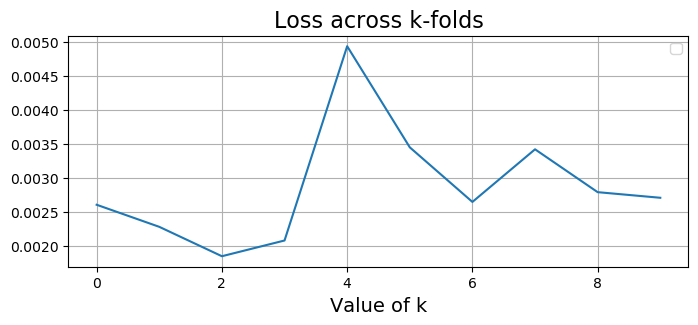

In [623]:
# Loss across k folds
plot_line(arr_loss, "Loss across k-folds", "Value of k")

### Loss curves

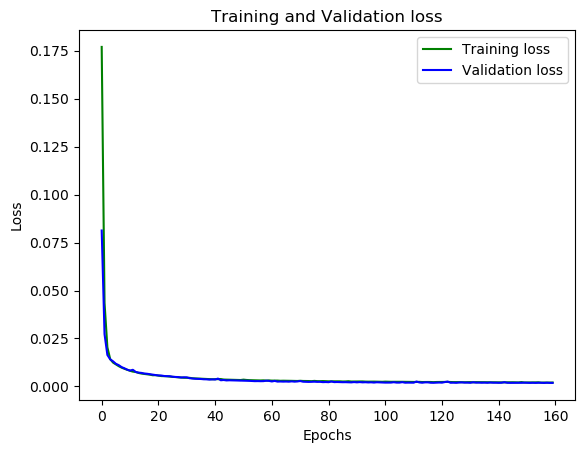

In [624]:
# Training and Validation Loss
plot_loss_curve(history_best_model, NUM_EPOCHS)

# Prediction on Test Dataset

In [625]:
# Normalize the test dataset
X_test_norm = scaler_input.transform(X_test)
y_test_norm = scaler_output.transform(y_test)

Elapsed time: 0.0219 seconds
Maxval here is:  35.763466
Maxval here is:  0.8844


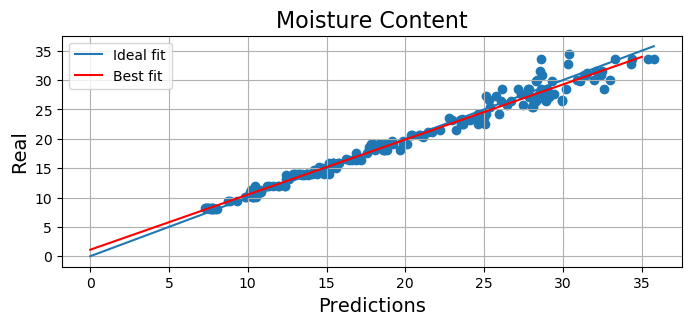

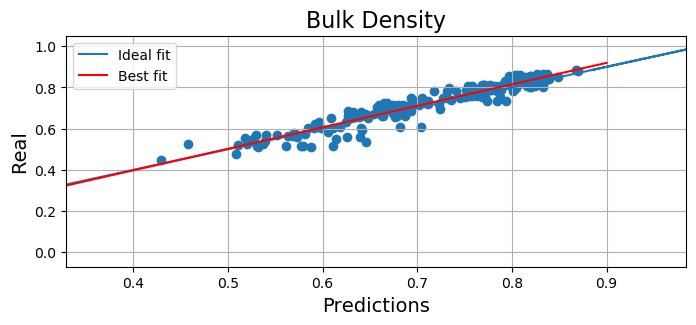

In [626]:
import time

start_time = time.time()
Y_pred_normalized = best_model.predict(X_test_norm)
end_time = time.time()
Y_pred_normalized_entire = best_model.predict(dataset_x_norm)
# Calculate elapsed time in seconds
elapsed_time = end_time - start_time
print("Elapsed time:", round(elapsed_time, 3), "seconds")


Y_pred = scaler_output.inverse_transform(Y_pred_normalized)
Y_pred_entire = scaler_output.inverse_transform(Y_pred_normalized_entire)
Y_actual = np.array(y_test)
Y_actual_entire = np.array(df_targets)
# Moisture Content
scatter_plot(trueValues=Y_actual[:,0], 
             predictions=Y_pred[:,0], 
             title="Moisture Content")
a, b = np.polyfit(Y_pred[:, 0], Y_actual[:, 0], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,0]), max(Y_actual[:,0])), 1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_MC.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Bulk Density
scatter_plot(trueValues=Y_actual[:,1], 
             predictions=Y_pred[:,1], 
             title="Bulk Density")
plt.xlim([min(min(Y_pred[:,1]), min(Y_actual[:,1]))-0.1, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1])
a, b = np.polyfit(Y_pred[:, 1], Y_actual[:, 1], 1) # y = ax + b
x_best_fit = np.arange(0, max(max(Y_pred[:,1]), max(Y_actual[:,1]))+0.1, 0.1)
plt.plot(x_best_fit, a*x_best_fit + b, c='red', label='Best fit')
plt.legend()
plt.savefig('../Poster/Results/obj_3_BD.svg', dpi=300,
                bbox_inches='tight',
                transparent=True)

# Error analysis
- R squared calculation
- Mean accuracy error

### R squared calculation

In [627]:
from sklearn.metrics import r2_score

# MOISTURE CONTENT
#   - R-squared
# mc_r2_score = r2_score(Y_actual[:, 0], Y_pred[:, 0])
mc_r2_score = calculate_r_squared(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("{:#.4g}".format(mc_r2_score))

# BULK DENSITY
#   - R-squared
# bd_r2_score = r2_score(Y_actual[:, 1], Y_pred[:, 1])
bd_r2_score = calculate_r_squared(y_true=Y_actual[:, 1], y_pred=Y_pred[:, 1])
print("{:#.4g}".format(bd_r2_score))


0.9789
0.9127


### RMSE

In [628]:
from sklearn.metrics import mean_squared_error
from sigfig import round

#MC
rmse_mc = np.sqrt(mean_squared_error(Y_actual[:, 0], Y_pred[:, 0]))
print('RMSE_MC: ', "{0:.4g}".format(rmse_mc))

#BD
rmse_bd = np.sqrt(mean_squared_error(Y_actual[:, 1], Y_pred[:, 1]))
print('RMSE_BD: ', "{0:.4g}".format(rmse_bd))

RMSE_MC:  1.199
RMSE_BD:  0.03352


Now we will compare with the results from Trabelsi's paper. This is single moisture prediction 

R^2 : 0.993\
Mean Squared Error: 0.028\
Mean absolute Error: 0.135\
Min. Absolute Error: 0.004\
Max Absolute Error: 0.441

In [629]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,max_error, r2_score
from sigfig import round

mc_r2_score = r2_score(y_true=Y_actual[:, 0], y_pred=Y_pred[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual[:, 0], Y_pred[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual[:, 0], Y_pred[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual[:,0])):
    sum = Y_actual[:,0][i] - Y_pred[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))




R^2: 0.9745
Mean Squared Error:  1.438
Mean Absolute Error:  0.8743
Min Absolute Error:  0.012550773620604971
Max Absolute Error:  4.931872177124021


In [630]:
mc_r2_score = r2_score(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print("R^2: {:#.4g}".format(mc_r2_score))
mse_mc = mean_squared_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0], squared=True)
print('Mean Squared Error: ', "{0:.4g}".format(mse_mc))
mae_mc = mean_absolute_error(Y_actual_entire[:, 0], Y_pred_entire[:, 0])
print('Mean Absolute Error: ', "{0:.4g}".format(mae_mc))

sums = []
for i in range(len(Y_actual_entire[:,0])):
    sum = Y_actual_entire[:,0][i] - Y_pred_entire[:,0][i]
    #print(Y_actual[:,0][i]," - ",Y_pred[:,0][i],'=',sum)
    sums.append(abs(sum))
print("Min Absolute Error: ",min(sums))
print("Max Absolute Error: ",max(sums))

R^2: 0.9795
Mean Squared Error:  1.065
Mean Absolute Error:  0.7733
Min Absolute Error:  0.0019256591796867895
Max Absolute Error:  4.931872177124021
